In [17]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from model import lorenz96_fdm
from model import M96 as M
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [5]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb_assum.npy')
R = np.load('./data/R.npy')

In [6]:
dt = 0.01

In [7]:
# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

In [8]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observation

#### `rmse_enkf` as CNTL in the later experiments

In [10]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

In [18]:
enkf = EnKF(lorenz96_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf.set_params(**params)
enkf.cycle()

1.237510861727948


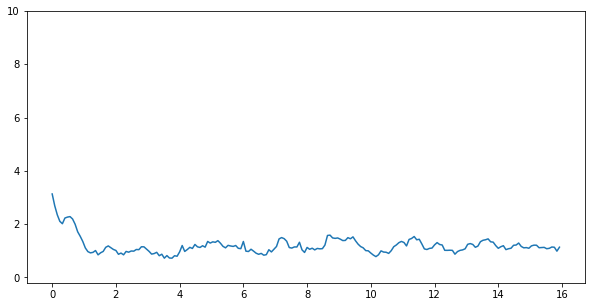

In [19]:
ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = RMSE(ens_mean, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts[::8], rmse_enkf[::8])
plt.ylim([-0.2, 10])
print(rmse_enkf.mean())

# First moment

### Assimilate bias observations based on normality test

In [20]:
# first moment
ex_obs_dict = pickle.load(open('./data/obs_bias_005_040.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.05', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40'])

obsm=0.05, Mean RMSE=1.1680, Variance RMSE=0.1158,  Without spinup: Mean RMSE=1.1320, Variance RMSE=0.0667
obsm=0.15, Mean RMSE=1.1376, Variance RMSE=0.0998,  Without spinup: Mean RMSE=1.1064, Variance RMSE=0.0601
obsm=0.20, Mean RMSE=1.1898, Variance RMSE=0.0834,  Without spinup: Mean RMSE=1.1548, Variance RMSE=0.0412
obsm=0.25, Mean RMSE=1.1167, Variance RMSE=0.0992,  Without spinup: Mean RMSE=1.0843, Variance RMSE=0.0619
obsm=0.30, Mean RMSE=1.3090, Variance RMSE=0.1782,  Without spinup: Mean RMSE=1.2733, Variance RMSE=0.1388
obsm=0.35, Mean RMSE=1.1368, Variance RMSE=0.1047,  Without spinup: Mean RMSE=1.0972, Variance RMSE=0.0513
obsm=0.40, Mean RMSE=1.2070, Variance RMSE=0.0894,  Without spinup: Mean RMSE=1.1758, Variance RMSE=0.0529


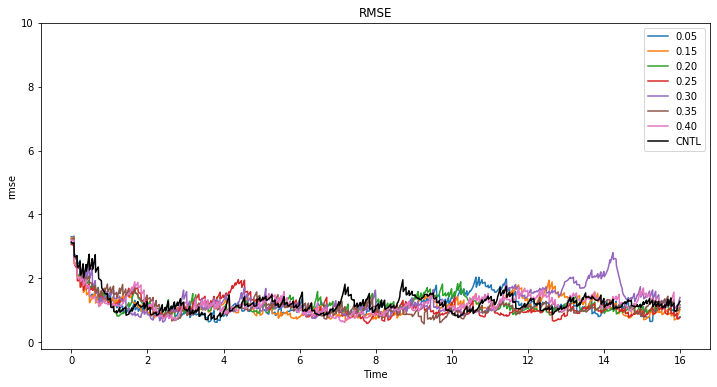

In [21]:
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm in ex_obs_dict.keys():
    obs = ex_obs_dict[obsm]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=obsm)
    
plt.plot(ts, rmse_enkf, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse')
plt.ylim([-0.2, 10]);

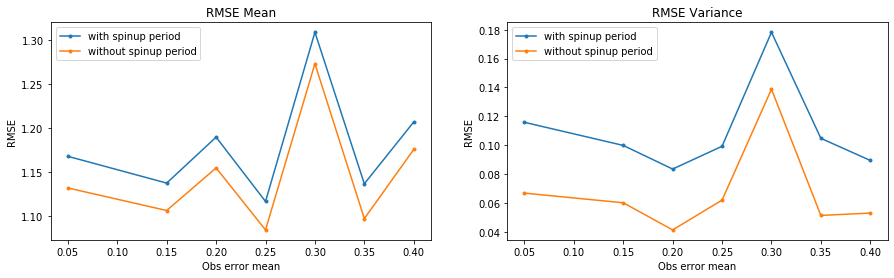

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_mean, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme bias observations

In [24]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))

obsm=0.20, Mean RMSE=1.1406, Variance RMSE=0.1025,  Without spinup: Mean RMSE=1.1010, Variance RMSE=0.0493
obsm=0.45, Mean RMSE=1.2290, Variance RMSE=0.0988,  Without spinup: Mean RMSE=1.1981, Variance RMSE=0.0653
obsm=0.70, Mean RMSE=1.1808, Variance RMSE=0.0705,  Without spinup: Mean RMSE=1.1559, Variance RMSE=0.0423
obsm=0.95, Mean RMSE=1.2156, Variance RMSE=0.0902,  Without spinup: Mean RMSE=1.1822, Variance RMSE=0.0503
obsm=1.20, Mean RMSE=1.2764, Variance RMSE=0.0667,  Without spinup: Mean RMSE=1.2526, Variance RMSE=0.0412
obsm=1.45, Mean RMSE=1.3514, Variance RMSE=0.0845,  Without spinup: Mean RMSE=1.3193, Variance RMSE=0.0480
obsm=1.70, Mean RMSE=1.4275, Variance RMSE=0.0981,  Without spinup: Mean RMSE=1.3938, Variance RMSE=0.0597
obsm=1.95, Mean RMSE=1.6557, Variance RMSE=0.1006,  Without spinup: Mean RMSE=1.6322, Variance RMSE=0.0782
obsm=2.20, Mean RMSE=1.6598, Variance RMSE=0.0930,  Without spinup: Mean RMSE=1.6449, Variance RMSE=0.0794
obsm=2.45, Mean RMSE=2.0093, Variance

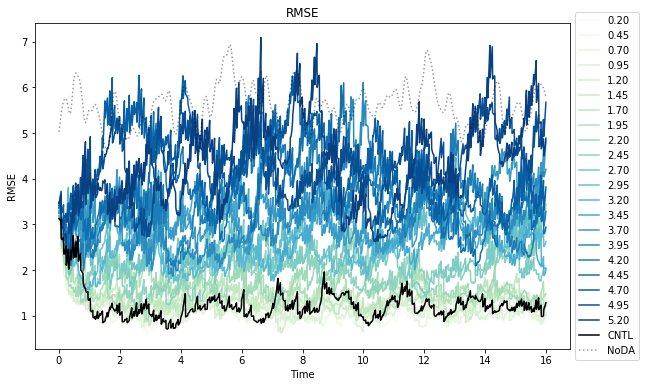

In [25]:
import matplotlib.cm as cm


mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))
colors = cm.GnBu(np.linspace(0, 1, len(ex_obs_dict.keys())))

for obsm, color in zip(ex_obs_dict.keys(), colors):
    obs = ex_obs_dict[obsm]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())
    
    plt.plot(ts, rmse, color=color, label=obsm)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')

# no DA
forecast = lorenz96_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

Text(0, 0.5, 'RMSE')

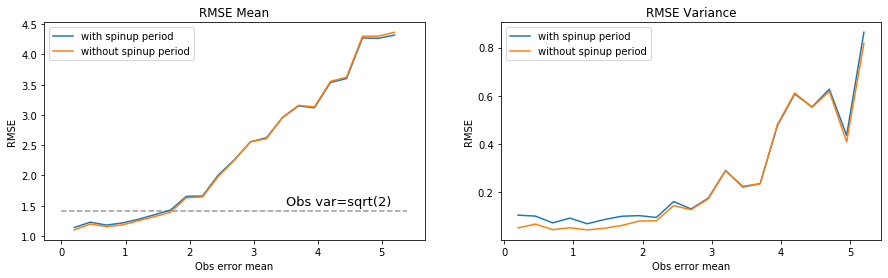

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=np.sqrt(2), xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(3.5, np.sqrt(2)+0.1, 'Obs var=sqrt(2)', fontsize=13)

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE')

# Third moment

### Assimilate skew observation based on normality test

In [27]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.15', '0.45', '0.75', '1.05', '1.35'])

alpha=0.15, Mean RMSE=1.3557, Variance RMSE=0.1401,  Without spinup: Mean RMSE=1.3186, Variance RMSE=0.0975
alpha=0.45, Mean RMSE=1.2154, Variance RMSE=0.1012,  Without spinup: Mean RMSE=1.1881, Variance RMSE=0.0702
alpha=0.75, Mean RMSE=1.2719, Variance RMSE=0.1113,  Without spinup: Mean RMSE=1.2397, Variance RMSE=0.0727
alpha=1.05, Mean RMSE=1.1741, Variance RMSE=0.1103,  Without spinup: Mean RMSE=1.1387, Variance RMSE=0.0679
alpha=1.35, Mean RMSE=1.3516, Variance RMSE=0.1702,  Without spinup: Mean RMSE=1.3236, Variance RMSE=0.1419


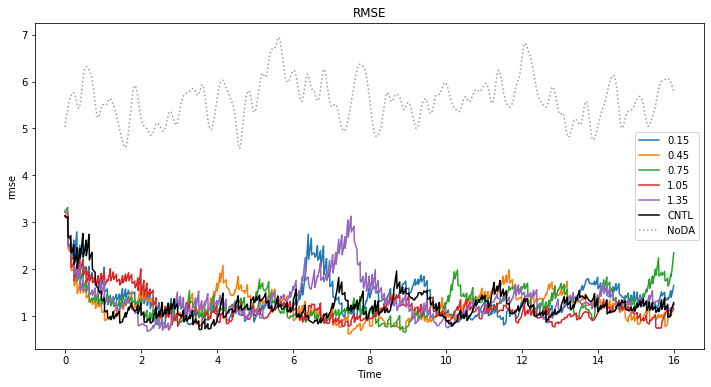

In [28]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz96_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

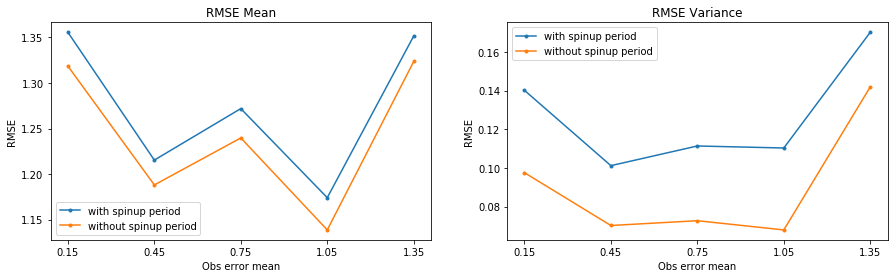

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme skewness

In [30]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

alpha=1.30, Mean RMSE=1.2542, Variance RMSE=0.0902,  Without spinup: Mean RMSE=1.2215, Variance RMSE=0.0501
alpha=1.55, Mean RMSE=1.2949, Variance RMSE=0.1127,  Without spinup: Mean RMSE=1.2623, Variance RMSE=0.0775
alpha=1.80, Mean RMSE=1.1852, Variance RMSE=0.0896,  Without spinup: Mean RMSE=1.1544, Variance RMSE=0.0527
alpha=2.05, Mean RMSE=1.1752, Variance RMSE=0.0925,  Without spinup: Mean RMSE=1.1327, Variance RMSE=0.0340
alpha=2.30, Mean RMSE=1.2377, Variance RMSE=0.1132,  Without spinup: Mean RMSE=1.2046, Variance RMSE=0.0746
alpha=2.55, Mean RMSE=1.2137, Variance RMSE=0.1186,  Without spinup: Mean RMSE=1.1737, Variance RMSE=0.0674
alpha=2.80, Mean RMSE=1.1521, Variance RMSE=0.1115,  Without spinup: Mean RMSE=1.1147, Variance RMSE=0.0663
alpha=3.05, Mean RMSE=1.2235, Variance RMSE=0.1220,  Without spinup: Mean RMSE=1.1837, Variance RMSE=0.0697
alpha=3.30, Mean RMSE=1.2154, Variance RMSE=0.1282,  Without spinup: Mean RMSE=1.1741, Variance RMSE=0.0713


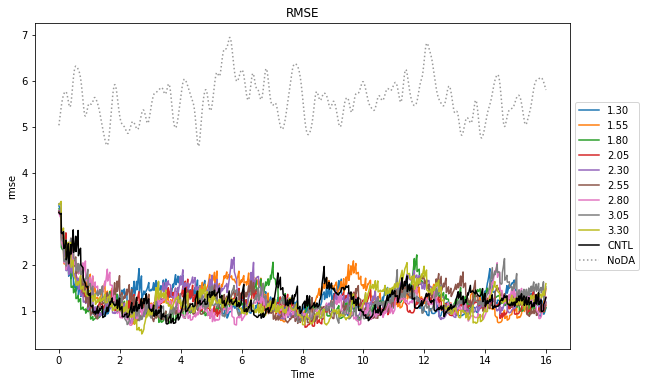

In [31]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz96_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

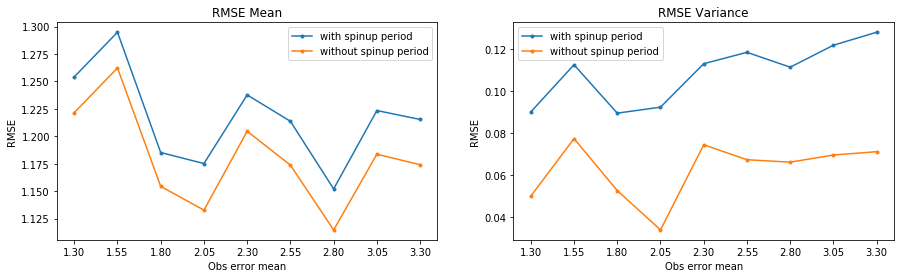

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Repeated assimilate skew observation based on normality test (repeat 10 times)

In [33]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[0.15, 0.45, 0.75, 1.05, 1.35]

In [34]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        enkf_params = {
            'X_ens_ini': X_ens_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'R': R, 
            'H_func': None, 
            'alpha': 0.3,
            'inflat': 1.4
        }

        enkf = EnKF(lorenz96_fdm, dt)
        enkf.set_params(**enkf_params)
        enkf.cycle()
        ens_mean = enkf.analysis.mean(axis=0)
        rmse += RMSE(ens_mean, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

0.15
0.45
0.75
1.05
1.35


alpha = 0.15, mean RMSE = 1.2615
alpha = 0.45, mean RMSE = 1.2746
alpha = 0.75, mean RMSE = 1.2360
alpha = 1.05, mean RMSE = 1.2668
alpha = 1.35, mean RMSE = 1.2936


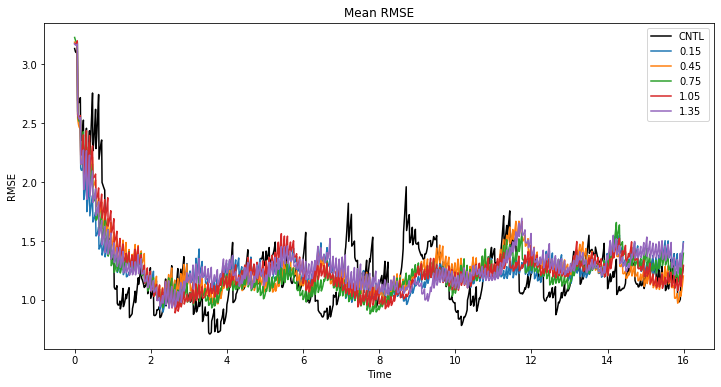

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_enkf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

### Repeated assimilate skew observations for more extreme alpha (repeat 10 times)

In [36]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_alpha = ex_obs_dict.keys()
ex_alpha = list(map(float, ex_alpha))
ex_alpha

[1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

In [37]:
from gen_skew_func import gen_skew_obs

rmse_dict = {}
for ex_a in ex_alpha:
    print(ex_a)
    rmse = np.zeros_like(ts)
    
    for _ in range(10):
        obs = gen_skew_obs(mean=0, var=2, alpha=ex_a, obs_intv=8)
        
        enkf_params = {
            'X_ens_ini': X_ens_ini, 
            'obs': obs, 
            'obs_interv': 8, 
            'R': R, 
            'H_func': None, 
            'alpha': 0.3,
            'inflat': 1.4
        }

        enkf = EnKF(lorenz96_fdm, dt)
        enkf.set_params(**enkf_params)
        enkf.cycle()
        ens_mean = enkf.analysis.mean(axis=0)
        rmse += RMSE(ens_mean, X_nature)

    rmse /= 10
    key = f'{ex_a:.2f}'
    rmse_dict[key] = rmse

1.3
1.55
1.8
2.05
2.3
2.55
2.8
3.05
3.3


alpha = 1.30, mean RMSE = 1.2822
alpha = 1.55, mean RMSE = 1.2713
alpha = 1.80, mean RMSE = 1.2579
alpha = 2.05, mean RMSE = 1.2529
alpha = 2.30, mean RMSE = 1.2241
alpha = 2.55, mean RMSE = 1.2405
alpha = 2.80, mean RMSE = 1.2430
alpha = 3.05, mean RMSE = 1.2510
alpha = 3.30, mean RMSE = 1.2402


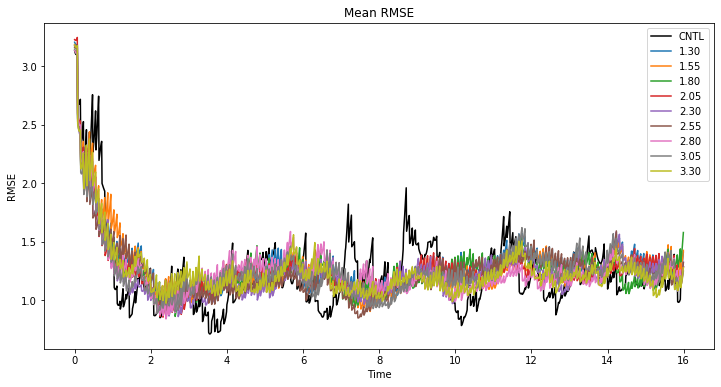

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(ts, rmse_enkf, 'k', label='CNTL')

for key, rmse in rmse_dict.items():
    print(f'alpha = {key}, mean RMSE = {rmse.mean():.4f}')
    plt.plot(ts, rmse, label=key)

plt.legend()
plt.title('Mean RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

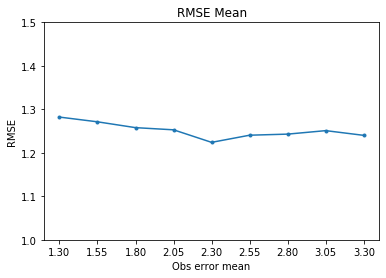

In [42]:
mean_rmse = []
for key, rmse in rmse_dict.items():
    mean_rmse.append(rmse.mean())


plt.plot(ex_alpha, mean_rmse, '.-')
plt.title('RMSE Mean')
plt.xticks(ex_alpha)
plt.xlabel('Obs error mean')
plt.ylabel('RMSE')
plt.ylim([1.0, 1.5]);

### Check the ratio of skew observation located bwteen -2*std ~ 2*std

In [43]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

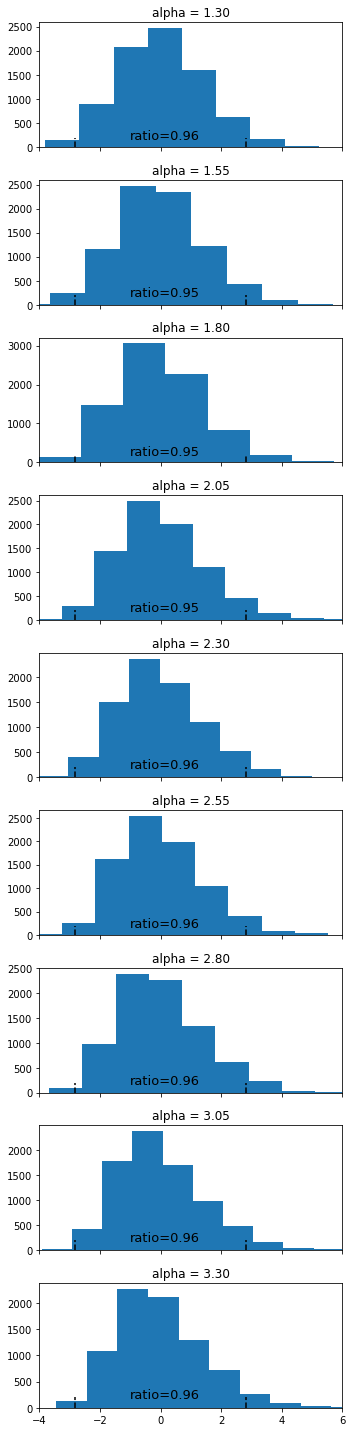

In [44]:
nrows = len(ex_obs_dict.keys())
fig, axs = plt.subplots(nrows=nrows, figsize=(5, 20), sharex=True)

for i, (key, obs) in enumerate(ex_obs_dict.items()):
    obserr = (obs - X_nature[:,::8]).ravel()
    axs[i].hist(obserr)
    
    std = np.sqrt(2)
    axs[i].vlines([2*std, -2*std], ymin=0, ymax=200, ls='dashed')
    axs[i].set_xlim([-4, 6])
    axs[i].set_title(f'alpha = {key}')
    
    total_size = obserr.size
    within_size = obserr[np.where((obserr <= 2*std) & (obserr >= -2*std))].size
    ratio = within_size / total_size
    axs[i].text(-1, 175, f'ratio={ratio:.2f}', fontsize=13)

plt.tight_layout()

# Fourth moment

### Assimilate kurtosis observation based on normality test

In [45]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_050_220.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.5', '0.6', '0.7', '0.8', '0.9', '1.2', '1.6', '1.8', '2.0', '2.2'])

delta=0.5, Mean RMSE=1.3557, Variance RMSE=0.1230,  Without spinup: Mean RMSE=1.3232, Variance RMSE=0.0885
delta=0.6, Mean RMSE=1.4143, Variance RMSE=0.1370,  Without spinup: Mean RMSE=1.3919, Variance RMSE=0.1176
delta=0.7, Mean RMSE=1.1753, Variance RMSE=0.0688,  Without spinup: Mean RMSE=1.1479, Variance RMSE=0.0333
delta=0.8, Mean RMSE=1.2263, Variance RMSE=0.0837,  Without spinup: Mean RMSE=1.1947, Variance RMSE=0.0485
delta=0.9, Mean RMSE=1.2672, Variance RMSE=0.1096,  Without spinup: Mean RMSE=1.2366, Variance RMSE=0.0756
delta=1.2, Mean RMSE=1.2929, Variance RMSE=0.1136,  Without spinup: Mean RMSE=1.2612, Variance RMSE=0.0778
delta=1.6, Mean RMSE=1.1106, Variance RMSE=0.1118,  Without spinup: Mean RMSE=1.0656, Variance RMSE=0.0455
delta=1.8, Mean RMSE=1.2410, Variance RMSE=0.1017,  Without spinup: Mean RMSE=1.2034, Variance RMSE=0.0541
delta=2.0, Mean RMSE=1.2385, Variance RMSE=0.1228,  Without spinup: Mean RMSE=1.1981, Variance RMSE=0.0717
delta=2.2, Mean RMSE=1.5074, Variance

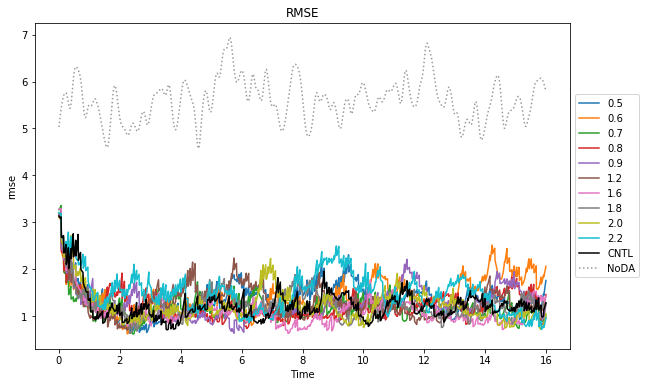

In [46]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz96_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

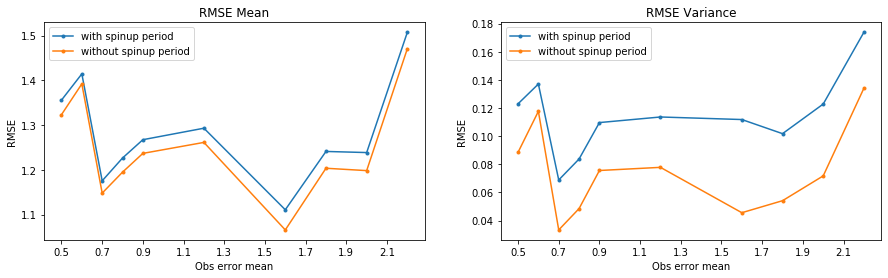

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_delta, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_delta, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

(-20, 20)

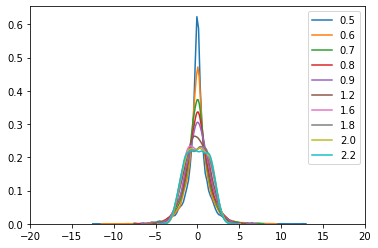

In [48]:
import seaborn as sns

fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### Assimilate kurtosis observation with more extreme delta

In [49]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_010_340.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.1', '0.2', '0.3', '0.4', '2.5', '2.8', '3.1', '3.4'])

delta=0.1, Mean RMSE=1.0033, Variance RMSE=0.2111,  Without spinup: Mean RMSE=0.9611, Variance RMSE=0.1521
delta=0.2, Mean RMSE=1.3071, Variance RMSE=0.1505,  Without spinup: Mean RMSE=1.2763, Variance RMSE=0.1153
delta=0.3, Mean RMSE=1.1841, Variance RMSE=0.1114,  Without spinup: Mean RMSE=1.1468, Variance RMSE=0.0624
delta=0.4, Mean RMSE=1.0868, Variance RMSE=0.0725,  Without spinup: Mean RMSE=1.0559, Variance RMSE=0.0336
delta=2.5, Mean RMSE=1.4277, Variance RMSE=0.1178,  Without spinup: Mean RMSE=1.3991, Variance RMSE=0.0888
delta=2.8, Mean RMSE=1.1534, Variance RMSE=0.1127,  Without spinup: Mean RMSE=1.1099, Variance RMSE=0.0524
delta=3.1, Mean RMSE=1.2231, Variance RMSE=0.1364,  Without spinup: Mean RMSE=1.1771, Variance RMSE=0.0707
delta=3.4, Mean RMSE=1.2938, Variance RMSE=0.1246,  Without spinup: Mean RMSE=1.2507, Variance RMSE=0.0673


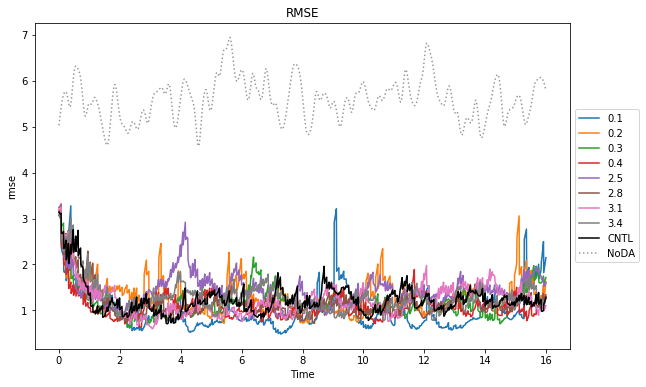

In [50]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse = RMSE(ens_mean, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_enkf, color='k', label='CNTL')
    
# no DA
forecast = lorenz96_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

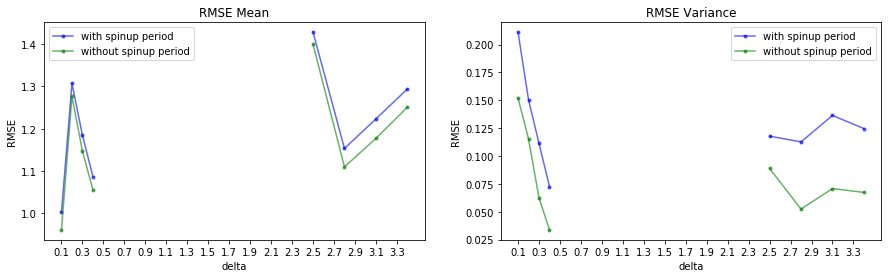

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta[:4], mean_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[0].plot(ex_delta[4:], mean_rmse[4:], 'b.-', alpha=0.6)
axs[0].plot(ex_delta[:4], mean_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[0].plot(ex_delta[4:], mean_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('delta')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta[:4], var_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[1].plot(ex_delta[4:], var_rmse[4:], 'b.-', alpha=0.6)
axs[1].plot(ex_delta[:4], var_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[1].plot(ex_delta[4:], var_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('delta')
axs[1].set_ylabel('RMSE');

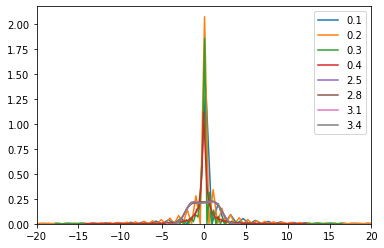

In [54]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20]);